In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import scipy.io as sio
import numpy as np

# Set device to GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [2]:
import os
import scipy.io as sio
import numpy as np

# Path to the MATLAB file
mat_file = os.path.join("Data", "Botnet_Detection.mat")

# Load the MATLAB file
data = sio.loadmat(mat_file)

# Print the keys in the MATLAB file
print("Keys in the .mat file:")
print(data.keys())

# Inspect each key's content if it is an array
for key in data.keys():
    # Skip the default keys added by MATLAB (those that start with '__')
    if key.startswith('__'):
        continue
    value = data[key]
    print(f"\nKey: {key}")
    print("Type:", type(value))
    print("Shape:", value.shape)
    print("Sample data (first 5 elements):")
    print(value.flat[:5])


Keys in the .mat file:
dict_keys(['__header__', '__version__', '__globals__', 'camera_motion', 'camera_streaming', 'extrusion', 'idle', 'masuta_when_idle', 'masuta_with_camera', 'mirai_extrusion', 'mirai_idle', 'mirai_loader', 'mirai_with_camera', 'mirai_with_router', 'mirai_with_voice', 'reboot', 'router', 'router_ftp', 'voice_assistant'])

Key: camera_motion
Type: <class 'numpy.ndarray'>
Shape: (7500, 1214)
Sample data (first 5 elements):
[2322.7996 1848.4739 2593.0518 2375.6792 2351.3965]

Key: camera_streaming
Type: <class 'numpy.ndarray'>
Shape: (7500, 1356)
Sample data (first 5 elements):
[1807.5135 2295.408  1946.121  2071.1233 2178.4712]

Key: extrusion
Type: <class 'numpy.ndarray'>
Shape: (7500, 2816)
Sample data (first 5 elements):
[1754.3162 1723.2656 2209.8035 1734.2009 1589.625 ]

Key: idle
Type: <class 'numpy.ndarray'>
Shape: (7500, 2490)
Sample data (first 5 elements):
[2186.7891 2015.361  1580.1116 1746.7391 1872.7076]

Key: masuta_when_idle
Type: <class 'numpy.ndarray'

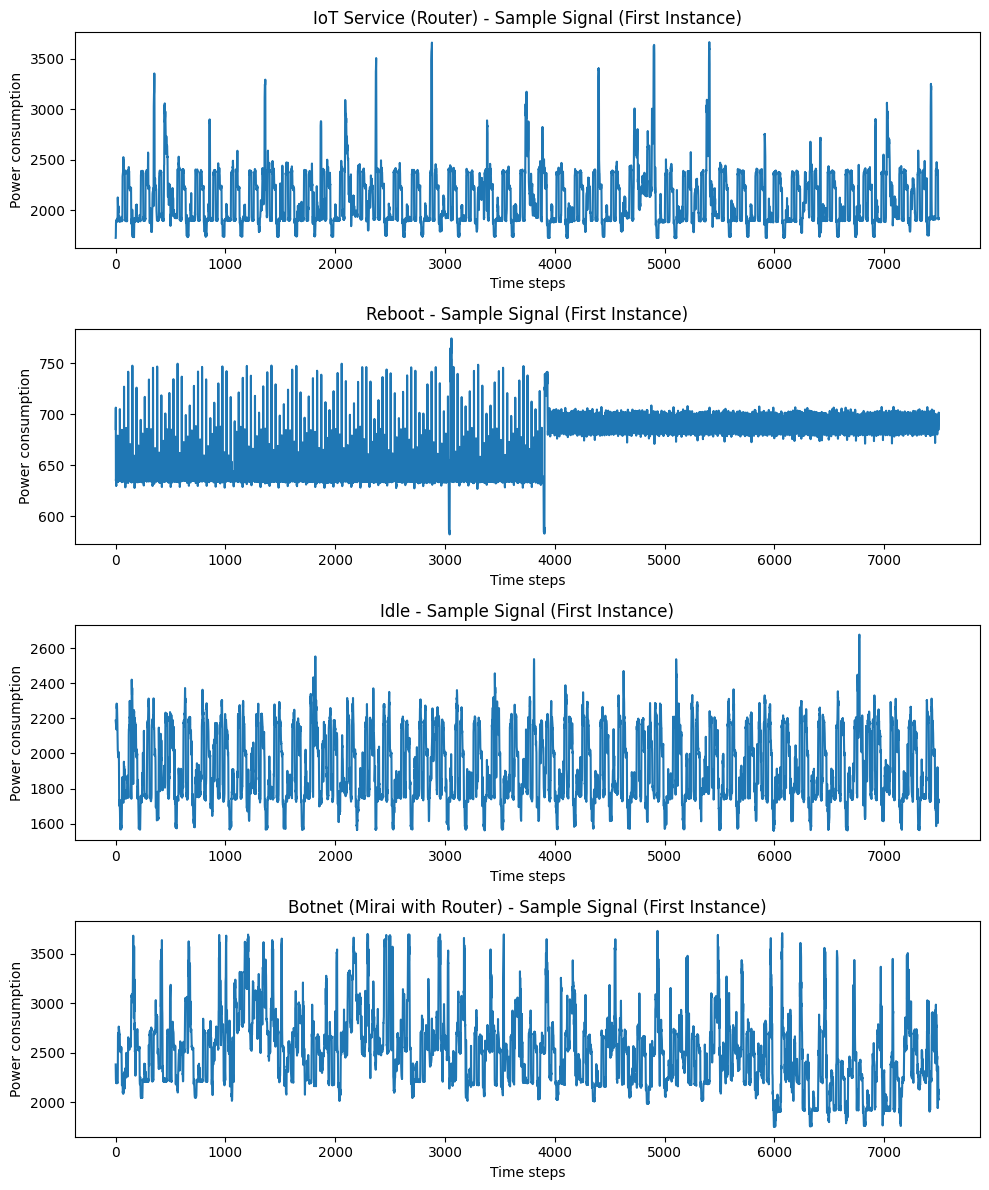

In [3]:
import matplotlib.pyplot as plt

# List of keys to visualize and their friendly names
keys_to_plot = {
    'router': 'IoT Service (Router)',
    'reboot': 'Reboot',
    'idle': 'Idle',
    'mirai_with_router': 'Botnet (Mirai with Router)'
}

fig, axes = plt.subplots(len(keys_to_plot), 1, figsize=(10, 3*len(keys_to_plot)))
if len(keys_to_plot) == 1:
    axes = [axes]  # ensure axes is iterable

for ax, (key, title) in zip(axes, keys_to_plot.items()):
    if key not in data:
        continue
    # data[key] shape is (7500, num_instances), so take first instance
    signal = data[key][:, 0]  # first instance
    ax.plot(signal)
    ax.set_title(f"{title} - Sample Signal (First Instance)")
    ax.set_xlabel("Time steps")
    ax.set_ylabel("Power consumption")
plt.tight_layout()
plt.show()


In [4]:
import torch
from torch.utils.data import Dataset

class CombinedBotnetDataset(Dataset):
    def __init__(self, mat_file, mapping, transform=None):
        """
        Args:
            mat_file (str): Path to the .mat file.
            mapping (dict): Dictionary mapping key names to label integers.
                            For example: {'router': 0, 'reboot': 1, 'idle': 2, 'mirai_with_router': 3}
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        # Load the MATLAB file
        mat_data = sio.loadmat(mat_file)
        self.data_list = []
        self.labels_list = []
        self.transform = transform
        
        # Loop over each key and label in the mapping
        for key, label in mapping.items():
            if key not in mat_data:
                raise KeyError(f"Key '{key}' not found in the .mat file. Available keys: {mat_data.keys()}")
            # Each key is assumed to have shape (7500, num_instances)
            data_array = mat_data[key]
            # Transpose so that each instance is a row: shape becomes (num_instances, 7500)
            data_array = data_array.T
            self.data_list.append(data_array)
            # Create a label array with the same number of instances
            self.labels_list.append(np.full((data_array.shape[0],), label))
        
        # Concatenate data and labels from all classes
        self.X = np.concatenate(self.data_list, axis=0)  # shape: (total_instances, 7500)
        self.Y = np.concatenate(self.labels_list, axis=0)  # shape: (total_instances,)
        
        # Add a channel dimension for 1D CNN input (expected shape: (instances, channels, length))
        self.X = np.expand_dims(self.X, axis=1)
        
        # Normalize each instance to have zero mean and unit variance
        self.X = (self.X - self.X.mean(axis=-1, keepdims=True)) / (self.X.std(axis=-1, keepdims=True) + 1e-8)

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        sample = torch.tensor(self.X[idx], dtype=torch.float32)
        label = torch.tensor(self.Y[idx], dtype=torch.long)
        if self.transform:
            sample = self.transform(sample)
        return sample, label

# Define mapping: key in .mat file -> label
mapping = {
    'router': 0,            # IoT service
    'reboot': 1,            # Reboot
    'idle': 2,              # Idle
    'mirai_with_router': 3  # Botnet (Mirai)
}

# Create dataset and inspect a few samples
dataset = CombinedBotnetDataset(mat_file, mapping)
print("Total dataset size:", len(dataset))
sample0, label0 = dataset[0]
print("Sample 0 shape:", sample0.shape)  # Expecting (1, 7500)
print("Sample 0 label:", label0)


Total dataset size: 8029
Sample 0 shape: torch.Size([1, 7500])
Sample 0 label: tensor(0)


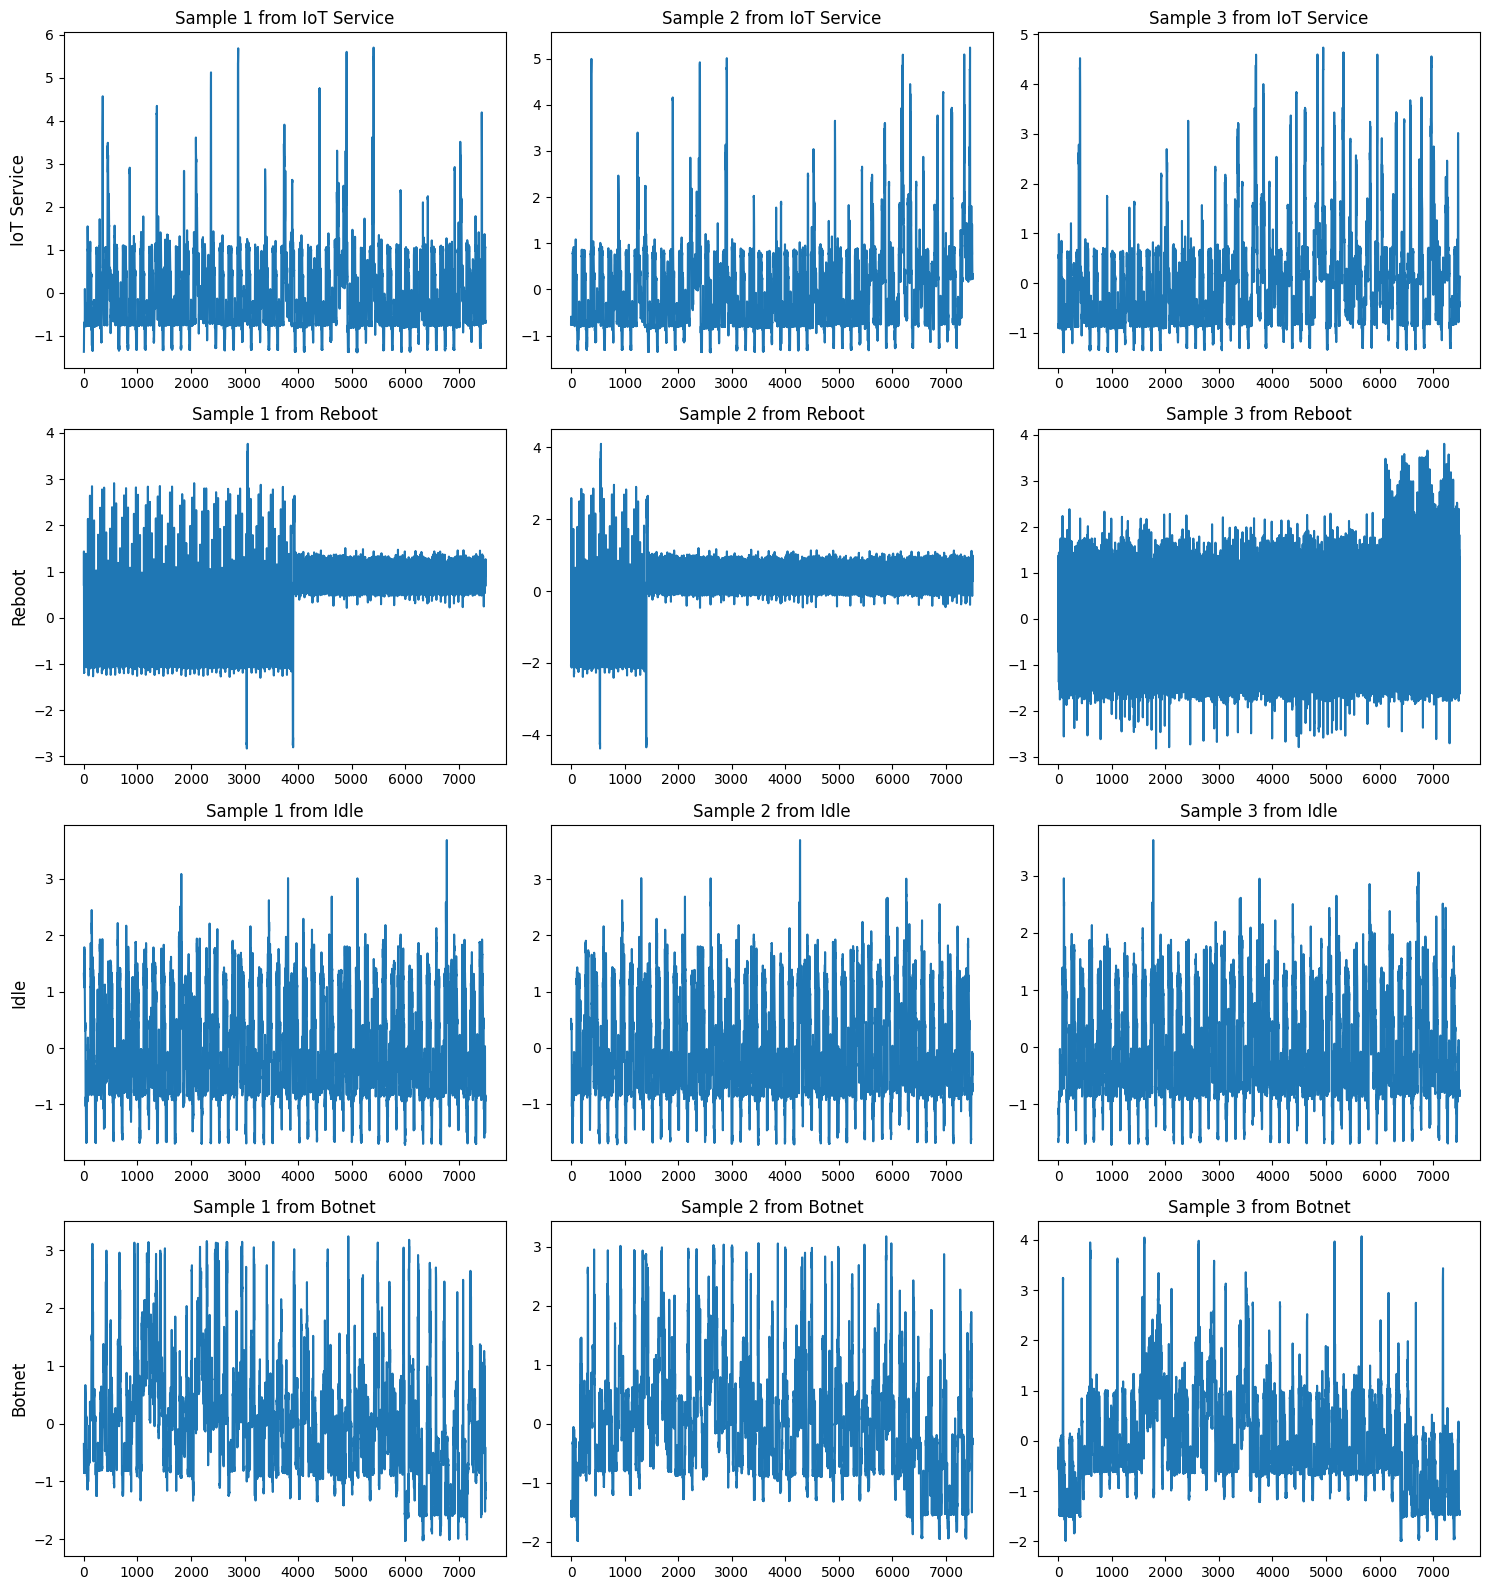

In [5]:
# For each class label, plot a few sample signals from the combined dataset
class_names = ['IoT Service', 'Reboot', 'Idle', 'Botnet']
samples_per_class = 3

fig, axes = plt.subplots(len(class_names), samples_per_class, figsize=(15, 4*len(class_names)))
for cls in range(len(class_names)):
    # Find indices corresponding to the class
    indices = np.where(dataset.Y == cls)[0]
    # Select a few samples
    for j in range(samples_per_class):
        if j >= len(indices):
            break
        sample, _ = dataset[indices[j]]
        # sample shape is (1, 7500), squeeze to (7500,)
        axes[cls, j].plot(sample.squeeze().cpu().numpy())
        if j == 0:
            axes[cls, j].set_ylabel(class_names[cls], fontsize=12)
        axes[cls, j].set_title(f"Sample {j+1} from {class_names[cls]}")
plt.tight_layout()
plt.show()


In [8]:
from torch.utils.data import random_split

# Get the total dataset size
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print(f"Total samples: {total_size}")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")


Total samples: 8029
Training samples: 5620
Validation samples: 1204
Test samples: 1205


In [9]:
# Function to count labels in a dataset
def count_labels(subset):
    labels = [label.item() for _, label in subset]
    counts = np.bincount(labels, minlength=len(class_names))
    return counts

train_counts = count_labels(train_dataset)
val_counts = count_labels(val_dataset)
test_counts = count_labels(test_dataset)

print("Label distribution in Training set:", dict(zip(class_names, train_counts)))
print("Label distribution in Validation set:", dict(zip(class_names, val_counts)))
print("Label distribution in Test set:", dict(zip(class_names, test_counts)))


Label distribution in Training set: {'IoT Service': 1710, 'Reboot': 1611, 'Idle': 1762, 'Botnet': 537}
Label distribution in Validation set: {'IoT Service': 374, 'Reboot': 357, 'Idle': 362, 'Botnet': 111}
Label distribution in Test set: {'IoT Service': 385, 'Reboot': 320, 'Idle': 366, 'Botnet': 134}


In [10]:
batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created.")



DataLoaders created.


In [11]:
import torch.nn as nn

class BotnetCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(BotnetCNN, self).__init__()
        # 1D Convolution: 10 filters, kernel size 512, stride 128
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=10, kernel_size=512, stride=128)
        # Batch Normalization after convolution
        self.bn1 = nn.BatchNorm1d(10)
        self.relu = nn.ReLU()
        # Max Pooling: kernel size 4, stride 4
        self.pool = nn.MaxPool1d(kernel_size=4, stride=4)
        
        # Estimate output length:
        # For input length 7500, conv1 output length ≈ floor((7500 - 512)/128) + 1 ≈ 55,
        # then pooling output length ≈ floor((55 - 4)/4) + 1 ≈ 13.
        conv_output_length = 13
        
        # Fully connected layers
        self.fc1 = nn.Linear(10 * conv_output_length, 128)
        self.fc_bn1 = nn.BatchNorm1d(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc_bn2 = nn.BatchNorm1d(64)
        # Output layer mapping to num_classes
        self.fc3 = nn.Linear(64, num_classes)
        
    def forward(self, x):
        # x shape: (batch_size, 1, 7500)
        x = self.conv1(x)       # -> (batch, 10, ~55)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.pool(x)        # -> (batch, 10, ~13)
        x = x.view(x.size(0), -1)  # Flatten: (batch, 10*13)
        x = self.fc1(x)         # -> (batch, 128)
        x = self.fc_bn1(x)
        x = self.relu(x)
        x = self.fc2(x)         # -> (batch, 64)
        x = self.fc_bn2(x)
        x = self.relu(x)
        x = self.fc3(x)         # -> (batch, num_classes)
        return x

# Instantiate the model and print its architecture
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BotnetCNN(num_classes=4).to(device)
print(model)


BotnetCNN(
  (conv1): Conv1d(1, 10, kernel_size=(512,), stride=(128,))
  (bn1): BatchNorm1d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=130, out_features=128, bias=True)
  (fc_bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc_bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=64, out_features=4, bias=True)
)


/home/wakili/anaconda3/envs/mlenv/lib/python3.8/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [12]:
import torch.optim as optim

# Hyperparameters
num_epochs = 20
learning_rate = 0.001

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

print(f"Training for {num_epochs} epochs with learning rate {learning_rate}.")


Training for 20 epochs with learning rate 0.001.


In [13]:
import copy

num_epochs = 20
best_val_acc = 0.0
best_model_wts = copy.deepcopy(model.state_dict())

train_loss_history = []
val_loss_history = []
train_acc_history = []
val_acc_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    
    # Training phase
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    train_loss = running_loss / total_train
    train_acc = 100. * correct_train / total_train
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)
    
    # Validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    val_loss = running_val_loss / total_val
    val_acc = 100. * correct_val / total_val
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    # Save best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_wts = copy.deepcopy(model.state_dict())

# Load best model weights
model.load_state_dict(best_model_wts)
print("Training complete. Best validation accuracy: {:.2f}%".format(best_val_acc))


Epoch [1/20] - Train Loss: 0.5211, Train Acc: 82.24%, Val Loss: 0.1406, Val Acc: 97.34%
Epoch [2/20] - Train Loss: 0.1223, Train Acc: 96.89%, Val Loss: 0.0734, Val Acc: 98.01%
Epoch [3/20] - Train Loss: 0.0664, Train Acc: 98.35%, Val Loss: 0.0575, Val Acc: 98.17%
Epoch [4/20] - Train Loss: 0.0390, Train Acc: 98.99%, Val Loss: 0.0513, Val Acc: 98.59%
Epoch [5/20] - Train Loss: 0.0333, Train Acc: 99.11%, Val Loss: 0.0525, Val Acc: 98.09%
Epoch [6/20] - Train Loss: 0.0292, Train Acc: 99.16%, Val Loss: 0.0650, Val Acc: 97.67%
Epoch [7/20] - Train Loss: 0.0261, Train Acc: 99.20%, Val Loss: 0.0634, Val Acc: 97.76%
Epoch [8/20] - Train Loss: 0.0226, Train Acc: 99.25%, Val Loss: 0.0498, Val Acc: 98.34%
Epoch [9/20] - Train Loss: 0.0218, Train Acc: 99.32%, Val Loss: 0.0402, Val Acc: 98.75%
Epoch [10/20] - Train Loss: 0.0104, Train Acc: 99.77%, Val Loss: 0.0472, Val Acc: 98.42%
Epoch [11/20] - Train Loss: 0.0101, Train Acc: 99.75%, Val Loss: 0.0413, Val Acc: 98.26%
Epoch [12/20] - Train Loss: 0.

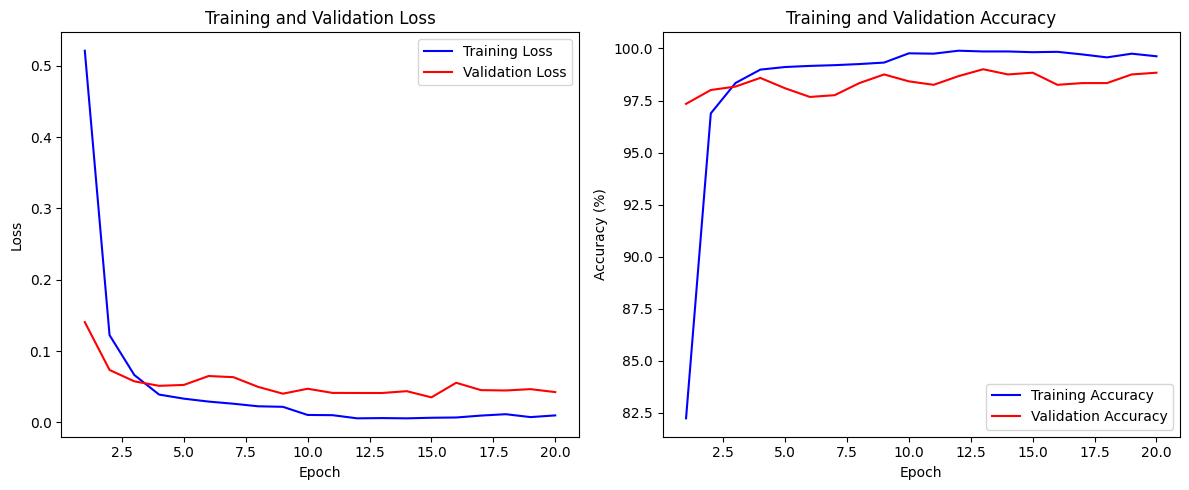

In [14]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs+1)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, 'b-', label='Training Loss')
plt.plot(epochs, val_loss_history, 'r-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc_history, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc_history, 'r-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report:
              precision    recall  f1-score   support

 IoT Service       0.97      0.98      0.98       385
      Reboot       1.00      1.00      1.00       320
        Idle       0.99      0.99      0.99       366
      Botnet       0.96      0.95      0.95       134

    accuracy                           0.99      1205
   macro avg       0.98      0.98      0.98      1205
weighted avg       0.99      0.99      0.99      1205



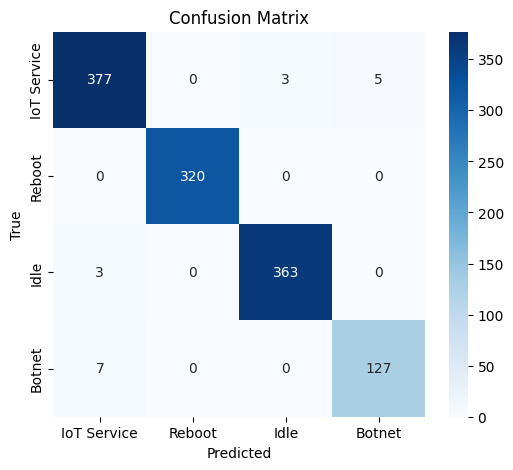

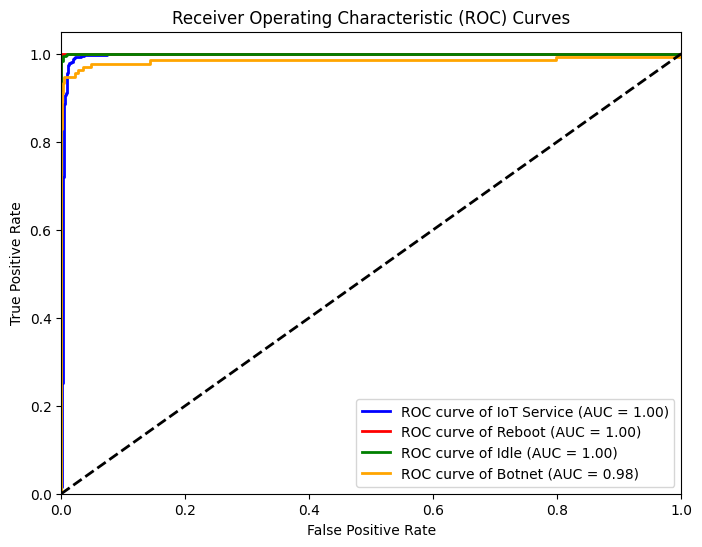

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Set model to evaluation mode
model.eval()
all_preds = []
all_labels = []
all_outputs = []  # For probability scores

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        all_outputs.extend(probs.cpu().numpy())

# Define class names (adjust if needed)
class_names = ['IoT Service', 'Reboot', 'Idle', 'Botnet']

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# ROC curves (One-vs-Rest)
# Convert lists to numpy arrays
all_labels = np.array(all_labels)
all_outputs = np.array(all_outputs)

# Binarize the output for ROC (one-hot encoding for labels)
from sklearn.preprocessing import label_binarize
all_labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))

# Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_labels_bin[:, i], all_outputs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'ROC curve of {class_names[i]} (AUC = {roc_auc[i]:.2f})')
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()
